In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from factor_analyzer import FactorAnalyzer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

## Outlier Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from factor_analyzer import FactorAnalyzer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

df1=pd.read_csv('data/stock_profit.csv')[['code','npMargin','netProfit','MBRevenue','epsTTM','totalShare','liqaShare']]
df2=pd.read_csv('data/stock_growth.csv')[['code','YOYEquity','YOYEPSBasic','YOYNI']]
df3=pd.read_csv('data/stock_balance.csv')[['code','liabilityToAsset','currentRatio','assetToEquity','YOYLiability']]
df4=pd.read_csv('data/stock_dupont.csv')[['code','dupontAssetTurn']]
df5=pd.read_csv('data/stock_industry.csv', encoding='GBK')[['code','code_name','industry']]
df6=pd.read_csv('data/stock_k_data(2024_01_02).csv')[['code','open','volume']]

df=pd.merge(df1,df2,on='code')
df=pd.merge(df,df3,on='code')
df=pd.merge(df,df4,on='code')
df=pd.merge(df,df5,on='code')
df=pd.merge(df,df6,on='code')
df=df[df['industry']=='化工']
df7=pd.read_csv('data/stock_k_data(2023_09_01).csv')[['code','open','volume']]
df7.rename(columns={
    'open': 'open_91',
    'volume': 'volume_91'
}, inplace=True)
df=pd.merge(df,df7,on='code')
df['open_dif']=df['open']-df['open_91']
df['volume_dif']=df['volume']-df['volume_91']
df=df.dropna().reset_index(drop=True)

In [2]:
columns_outliers=['npMargin', 'netProfit', 'epsTTM', 'totalShare','liqaShare','YOYEquity','MBRevenue','YOYNI',
       'YOYEPSBasic', 'liabilityToAsset', 'currentRatio', 'assetToEquity',
       'YOYLiability', 'dupontAssetTurn','open_dif','volume_dif']
X_ = df[columns_outliers]
scaler = StandardScaler()
X_ = pd.DataFrame(scaler.fit_transform(X_),columns = X_.columns)

In [3]:
def remove_outliers(series):
    mean = series.mean()
    std = series.std()
    threshold = 3  # 可调整阈值
    return abs(series - mean) <= threshold * std
outliers=X_[-X_.apply(remove_outliers).all(axis=1)]

In [4]:
outliers.head()

,npMargin,netProfit,epsTTM,totalShare,liqaShare,YOYEquity,MBRevenue,YOYNI,YOYEPSBasic,liabilityToAsset,currentRatio,assetToEquity,YOYLiability,dupontAssetTurn,open_dif,volume_dif
0,-0.028470,9.917804,0.202868,18.783470,19.933453,-0.148772,20.221636,0.098285,0.109204,0.602678,-0.626555,0.010559,-0.239059,2.767545,0.002503,3.777509
8,-8.841648,-0.187907,-1.248456,-0.094166,-0.072488,-3.218366,-0.104536,-0.100838,-0.243589,2.401462,-0.906393,2.861271,-0.191515,-1.602222,-0.013832,0.294006
13,0.252471,0.591175,0.547032,0.841388,1.175322,-0.224216,0.282730,0.049959,0.036989,0.542886,-0.709967,-0.014706,-0.527251,1.068663,0.242855,3.071187
17,0.369412,2.506860,6.135390,0.296364,0.448387,0.386672,0.992083,0.114589,0.129591,1.124443,-0.726856,0.296675,0.312231,0.350081,-3.810466,-0.255851
28,2.354514,-0.103495,-0.304716,-0.076060,-0.048340,0.430198,-0.105413,0.476956,0.686241,-1.779281,3.687798,-0.514634,-1.345427,-1.098147,0.205519,0.992703


## 肘部法＋Kmeans

d:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


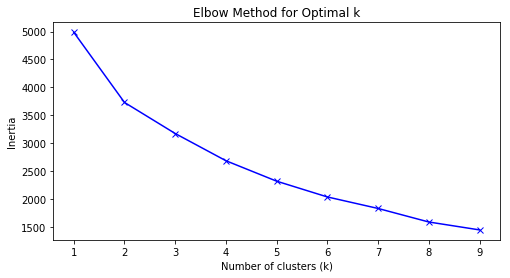

In [5]:
# 使用肘部法则选择适当的聚类数目
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(outliers)
    inertia.append(kmeans.inertia_)

# 绘制肘部法则图
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [6]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(outliers)
outliers['Cluster'] = kmeans.labels_

d:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## PCA

d:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
d:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
d:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

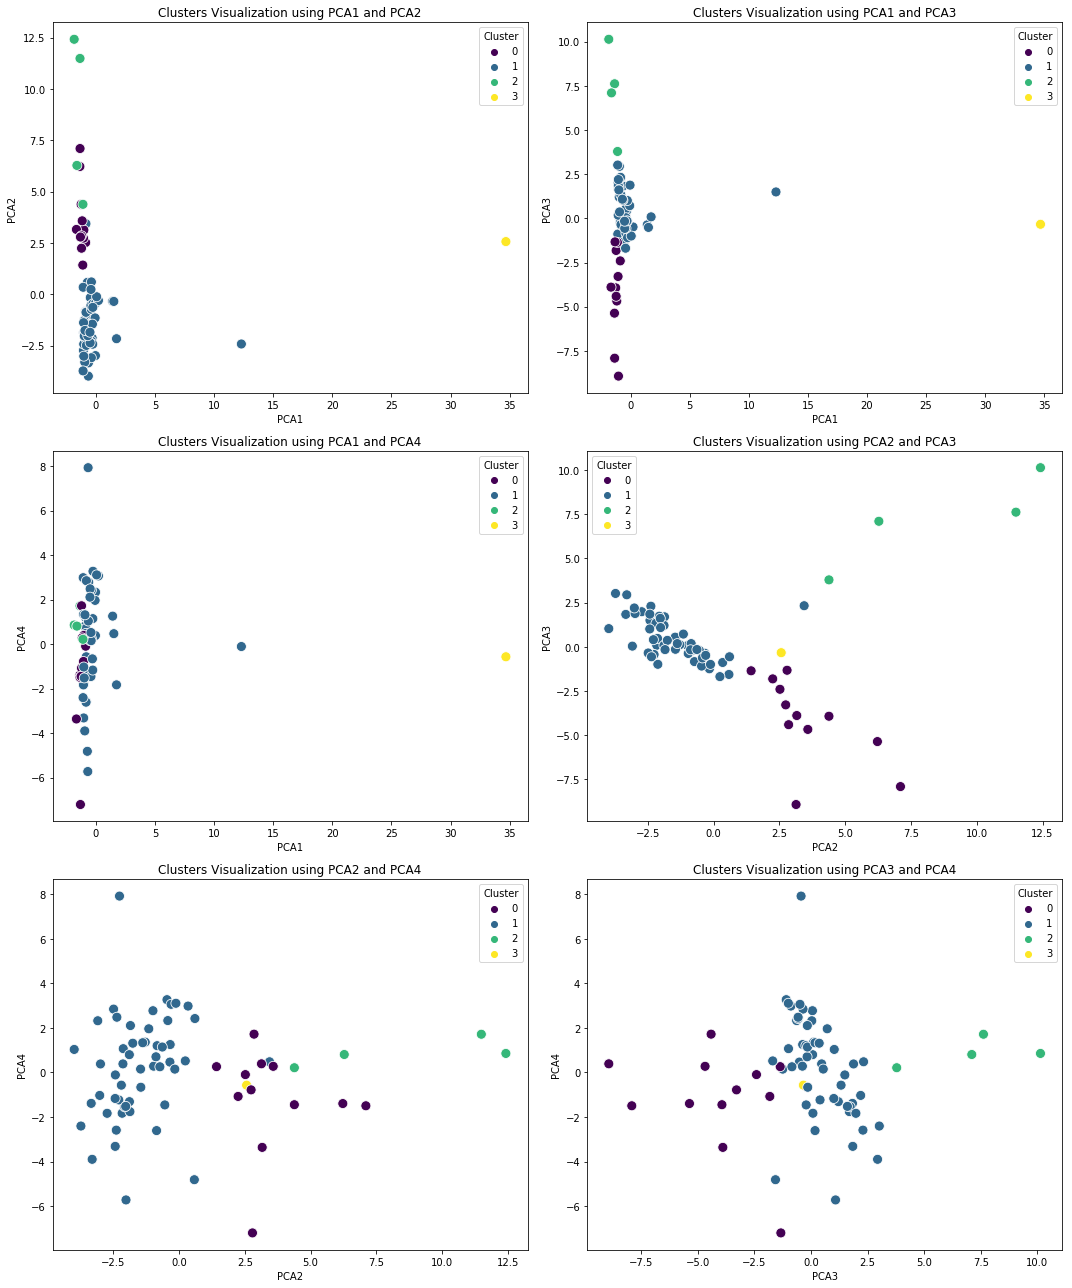

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.decomposition import PCA
# 假设 scaled_outlier 已经存在且已预处理

# 执行PCA生成4个组件
pca = PCA(n_components=4)
pca_data = pca.fit_transform(outliers.drop(columns=['Cluster']))
outliers['PCA1'] = pca_data[:, 0]
outliers['PCA2'] = pca_data[:, 1]
outliers['PCA3'] = pca_data[:, 2]
outliers['PCA4'] = pca_data[:, 3]

# 生成所有两两组合的图
combinations_of_pca = list(combinations(['PCA1', 'PCA2', 'PCA3','PCA4'], 2))

# 设置绘图的子图网格大小
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# 遍历所有组合并绘制子图
for (ax, (pca_x, pca_y)) in zip(axes.flatten(), combinations_of_pca):
    sns.scatterplot(data=outliers, x=pca_x, y=pca_y, hue='Cluster', palette='viridis', s=100, ax=ax)
    ax.set_title(f'Clusters Visualization using {pca_x} and {pca_y}')

# 调整子图布局
plt.tight_layout()
plt.show()

In [8]:
components = pca.components_

# 打印PCA1和PCA2的成分
print("PCA1 components:\n", components[0])
print("PCA2 components:\n", components[1])
print("PCA3 components:\n", components[2])
print("PCA4 components:\n", components[3])

PCA1 components:
 [ 0.04500503  0.40502084  0.05517944  0.53175212  0.49948553  0.00451559
  0.52302698  0.03762595  0.04143288  0.00374542 -0.04859126 -0.0352302
 -0.03591618  0.07399968  0.01029021  0.10697502]
PCA2 components:
 [-0.40031401 -0.05077807 -0.29007453  0.0452728   0.07467418 -0.25423459
  0.05884688 -0.49351047 -0.4449271   0.2580899  -0.25225861  0.30204999
 -0.09944124 -0.06561266  0.00793109 -0.00740328]
PCA3 components:
 [ 0.33421591  0.04335873  0.11411561  0.00777803 -0.0105262  -0.01279842
 -0.00517954 -0.48313073 -0.48651063 -0.26537766  0.28434007 -0.49978609
 -0.02380882 -0.01254593 -0.03264757  0.00875854]
PCA4 components:
 [ 0.05495406 -0.02758926  0.12691308 -0.02971489 -0.03191298  0.24649071
 -0.03763334 -0.10838487 -0.06689401  0.07459446 -0.3103062  -0.05034787
  0.34437335  0.13095438  0.73560257  0.34434307]


## 筛选出各个主成分中权重绝对值大于0.3的部分，研究其背后意义，给出解释方差比例

In [9]:

for j in range(4):
    indices = [i for i, x in enumerate(components[j]) if abs(x) > 0.3]
    weight=[x for i, x in enumerate(components[j]) if abs(x) > 0.3]
    print(indices,weight)
    selected_columns = outliers.columns[indices]
    result_table = pd.DataFrame({'Selected "Columns': selected_columns})
    print(result_table)

[1, 3, 4, 6] [0.40502084185158366, 0.5317521169307051, 0.49948553379260885, 0.5230269801122153]
  Selected "Columns
0         netProfit
1        totalShare
2         liqaShare
3         MBRevenue
[0, 7, 8, 11] [-0.4003140133937644, -0.49351046859334796, -0.44492710476207503, 0.3020499887579804]
  Selected "Columns
0          npMargin
1             YOYNI
2       YOYEPSBasic
3     assetToEquity
[0, 7, 8, 11] [0.3342159061275348, -0.4831307349882041, -0.48651063486113777, -0.49978608680520237]
  Selected "Columns
0          npMargin
1             YOYNI
2       YOYEPSBasic
3     assetToEquity
[10, 12, 14, 15] [-0.31030620403331227, 0.34437334598416064, 0.735602565310454, 0.34434307269149494]
  Selected "Columns
0      currentRatio
1      YOYLiability
2          open_dif
3        volume_dif


PCA1：净利润、总股本、流通股本、主营营业收入 (代表了总体量)\
PCA2：销售净利率(-)、净利润同比增长率(-)、基本每股收益同比增长率(-)、权益乘数(+) （代表经营不善，财务负担重，收益减少，融资面广）\
PCA3：销售净利率(+)、净利润同比增长率(-)、基本每股收益同比增长率(-)、权益乘数(-)  (有盈利，但本季度收益减少，融资面较窄) \
PCA4: 流动比率(-)、总负债同比增长率(+)、股价上升(+)、成交量上升(+)  （高负债运营的公司，短期上升发展）


In [10]:
# 获取解释方差
explained_variance = pca.explained_variance_

# 获取解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_

# 输出结果
for i, (var, ratio) in enumerate(zip(explained_variance, explained_variance_ratio), start=1):
    print(f"主成分{i}: 解释方差 = {var:.4f}, 解释方差比例 = {ratio:.4f}")

主成分1: 解释方差 = 20.4969, 解释方差比例 = 0.2836
主成分2: 解释方差 = 10.6914, 解释方差比例 = 0.1479
主成分3: 解释方差 = 8.2925, 解释方差比例 = 0.1147
主成分4: 解释方差 = 5.3402, 解释方差比例 = 0.0739


## 先看大公司（PCA1大的）

In [15]:
df8=pd.read_csv('data/stock_k_data(2024_04_01).csv')[['code','open','volume']]
df8.rename(columns={
    'open': 'open_41',
    'volume': 'volume_41'
}, inplace=True)
selected_result=pd.merge(df,df8,on='code')
selected_result['open_diff_4_1']=selected_result['open_41']-selected_result['open']

In [43]:
big_company_index=outliers[(outliers['PCA1']>10)].index

In [44]:
selected_result.loc[big_company_index][['code_name','open_diff_4_1']]

,code_name,open_diff_4_1
0,中国石化,0.81
51,中国海油,8.31


## 在筛选别的可能表现良好的公司

In [45]:
potential_company_index=outliers[(outliers['PCA3']>0.5)&(outliers['PCA2']<-1)&(outliers['PCA4']>-0.5)].index

In [46]:
selected_result.loc[potential_company_index][['code_name','open_diff_4_1']]


,code_name,open_diff_4_1
51,中国海油,8.31
173,藏格矿业,5.80
209,大庆华科,-1.83
277,道明光学,-1.55
399,科思股份,16.19


## Outlier中实际实现24年第一季度股价上涨的公司：

In [49]:
selected_result.loc[outliers.index][selected_result['open_diff_4_1']>1][['code_name','open_diff_4_1']]

d:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,code_name,open_diff_4_1
17,万华化学,6.50
36,*ST榕泰,1.35
51,中国海油,8.31
119,中农立华,2.45
173,藏格矿业,5.80
324,当升科技,1.06
390,中简科技,1.05
399,科思股份,16.19
406,中伟股份,4.52
